# Session 2: Object Detection and Segmentation with Detectron2

---

## Question 1: Split the dataset in a training and a test set.

Hint: you can use the following repo for this: https://github.com/GillesDep/cocosplit

Note: It is possible that in a custom dataset, you get an error like this: "Category ids in
annotations are not in [1, #categories]! We'll apply a mapping for you.", this means that
somewhere in the json file there is a category with index 0. In this case, you will have to
change all these indices to a non-zero integer. Also do not forget to adjust the "categories"
entry in the json in that case. This problem should not occur on the dataset I prepared for
you.

This is the command I used:
```
python cocosplit.py -s 0.3 /home/atvars/School/advanced_ai/session2/chickens/data/_annotations.coco.json /home/atvars/School/advanced_ai/session2/chickens/train_annotations.json /home/atvars/School/advanced_ai/session2/chickens/test_annotations.json
```

The split is how large the training set is, so I had to change the name of the annotation files, because the test set ended up being 70% of the data.

---
## Question 2: What type of Deep Learning Model is best for this problem and why?

1. I should use a Convolutional neural network, because this is a computer vision problem, and these kinds of networks work best on this kind of data.
2. Since it's not that pressing of an issue to detect the chickens in real-time, I can instead focus on accuracy. So no YOLO model.
3. I think I will use the Detectron2 model, because I already have both pytorch, and the model itself installed.
4. From the model's github repository:
>Detectron includes implementations of the following object detection algorithms:
>- Mask R-CNN -- Marr Prize at ICCV 2017
>- RetinaNet -- Best Student Paper Award at ICCV 2017
>- Faster R-CNN
>- RPN
>- Fast R-CNN
>- R-FCN

So the model has a lot of flexibility on how it makes detections. This is good, because I want to experiment with the detection techniques to find the optimal one.

5. The model was trained on the coco dataset, which is great, because the annotations I have are also formatted this way.

---
## Question 3: Look for the right config file and model. Where is this info available? Why this model? 

In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

/bin/bash: line 1: nvcc: command not found
torch:  2.6 ; cuda:  cu124
detectron2: 0.6


In [2]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_test_loader
from detectron2.structures import BoxMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

### Where is this info available?
`detectron2/detectron2/model_zoo/configs/` contains various configurations for this model.

But I looked [here](https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md) on the model's repo to see various configurations and their explanations.

From the available models, I chose **faster_rcnn_X_101_32x8d_FPN_3x.yaml**

### Why this model?

It's an object detection model, so I will be able to count the number of chickens in each image.

It takes longer to train, but has the highest `Box Average Precision` from all the Detectron2 COCO configs.
- Besides, I am not training it on a large dataset, so the slower speed will not impact me that much.



In [3]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")) #select config
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml") #select model from model zoo

Getting train and test sets

In [4]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "train_annotations.json", "/home/atvars/School/advanced_ai/session2/chickens/data")
register_coco_instances("my_dataset_val", {}, "test_annotations.json", "/home/atvars/School/advanced_ai/session2/chickens/data")

In [ ]:
with open("config.yaml", "w") as file: # So I can read the config in my IDE
    file.write(cfg.dump())

---
## Question 4: What are the best settings and hyperparameters for the config file and why? More specifically, do this:


1. Add test set in the config file, this has not been done in the demo
2. Choose a batch size of 2
3. The network should see every image about 10 times during training, set the amount of
iterations to 5000 for this.
4. Schedule the evolution of your learning rate using the following info:
a. There is learning rate warmup: the learning rate increases slightly from epoch 0 until
it reaches its base learning rate at epoch 1000. This is proven to be a good method.
b. The base learning rate at epoch 1000 is 0.01
c. It should be reduced by a factor 10 after 2000 and after 3500 iterations.
Don't worry about the factor 10 and the warmup, this is standard. But set the base
learning rate and the steps yourself.
5. Set NUM_CLASSES to the right value
6. Filter out images with no annotations. Why should we not include these images?
7. Store your output in a folder 'output' to your choice.

Note: If you work with long and thin objects in your own applications, it is worthwhile to check the
ANCHOR_GENERATOR.ASPECT_RATIOS parameter. This is not necessary for this assignment.

Note 2: If the training of the model takes a very long time (more than 2 hours), you can reduce the
amount of iterations to 1000. Please mention this if this is the case.

In [ ]:
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.SOLVER.IMS_PER_BATCH = 2 # batch size
cfg.SOLVER.MAX_ITER = 5000
###############################################################
#               Learning rate scheduler settings              #
###############################################################
# Set the base learning rate at epoch 1000
cfg.SOLVER.BASE_LR = 0.01  

# Warmup: Learning rate increases from 0 until it reaches BASE_LR at iteration 1000
cfg.SOLVER.WARMUP_ITERS = 1000  
cfg.SOLVER.WARMUP_METHOD = "linear"  # Standard warmup method
cfg.SOLVER.WARMUP_FACTOR = 0.001  # Standard factor

# Reduce learning rate by a factor of 10 at iterations 2000 and 3500
cfg.SOLVER.STEPS = (2000, 3500)  
cfg.SOLVER.GAMMA = 0.1  # Standard decay factor

# Set maximum iterations
cfg.SOLVER.MAX_ITER = 4000  
###############################################################
# cfg.MODEL.ROI_BOX_HEAD.FED_LOSS_NUM_CLASSES = 1  # Only one class
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 # Only one class

###############################################################
#              Making Sure Model Runs on CUDA                 #
###############################################################
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", cfg.MODEL.DEVICE)

Device:  cuda


In [7]:
# Removing the previously registered datasets

test_set_name = "my_dataset_val"
train_set_name = "my_dataset_train"


In [8]:
from detectron2.data import DatasetCatalog

def filter_empty_images(dataset_name):
    dataset_dicts = DatasetCatalog.get(dataset_name)
    filtered_dataset = [d for d in dataset_dicts if len(d["annotations"]) > 0]
    return filtered_dataset

# Re-register the filtered datasets
filtered_dataset = filter_empty_images(train_set_name)
DatasetCatalog.remove(train_set_name)
MetadataCatalog.remove(train_set_name)
# Overwrite DatasetCatalog with filtered dataset
DatasetCatalog.register(train_set_name, lambda: filtered_dataset)

filtered_dataset = filter_empty_images(test_set_name)
DatasetCatalog.remove(test_set_name)
MetadataCatalog.remove(test_set_name)
# Overwrite DatasetCatalog with filtered dataset
DatasetCatalog.register(test_set_name, lambda: filtered_dataset)


[03/08 18:14:44 d2.data.datasets.coco]: Loaded 263 images in COCO format from train_annotations.json
[03/08 18:14:44 d2.data.datasets.coco]: Loaded 112 images in COCO format from test_annotations.json


---
## Question 5: During training in the demo notebook, you could only see intermediate results on the training set. You should also test your model every 100 iterations on the test set.

Hint1: set the right parameter in the cfg file to 100

Hint2: Implement a class 'MyTrainer' that applies COCOEvaluator on the dataset. Google is
your friend :-)

Note: Data augmentation can also be implemented this way. Check
[here](https://detectron2.readthedocs.io/en/latest/tutorials/augmentation.html) for more info.

In [ ]:
# Make the model evaluate itself every 100 iterations
cfg.TEST.EVAL_PERIOD = 100

I had an error:

`Attribute 'thing_classes' does not exist in the metadata of dataset 'my_dataset_val'. Available keys are dict_keys(['name', 'json_file']).`

So the next cell needs to be run.

The problem is that Detectron2 expects `thing_classes` in the metadata, however the `cocosplit.py` script does not set this variable.
The next cell sets it.

I get the name "Chicken" from the test_annotations.json file line `27930`.

In [10]:
MetadataCatalog.get(train_set_name).thing_classes = ["Chicken"] 
MetadataCatalog.get(test_set_name).thing_classes = ["Chicken"]

In [11]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name): # Trainer finds validation set, because I defined it before in the model's config
        return COCOEvaluator(dataset_name, cfg, False, output_dir=cfg.OUTPUT_DIR)


In [11]:
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[03/07 14:52:42 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, we

[03/07 14:52:43 d2.engine.train_loop]: Starting training from iteration 0


/home/atvars/miniconda3/envs/Advanced_AI/lib/python3.10/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[03/07 14:53:02 d2.utils.events]:  eta: 1:03:02  iter: 19  total_loss: 0.8728  loss_cls: 0.5184  loss_box_reg: 0.3053  loss_rpn_cls: 0.0168  loss_rpn_loc: 0.008187    time: 0.9129  last_time: 0.9459  data_time: 0.0068  last_data_time: 0.0020   lr: 0.00019981  max_mem: 3894M
[03/07 14:53:20 d2.utils.events]:  eta: 1:02:05  iter: 39  total_loss: 0.5034  loss_cls: 0.1737  loss_box_reg: 0.3218  loss_rpn_cls: 0.001521  loss_rpn_loc: 0.006192    time: 0.9075  last_time: 0.9305  data_time: 0.0023  last_data_time: 0.0018   lr: 0.00039961  max_mem: 3894M
[03/07 14:53:38 d2.utils.events]:  eta: 1:01:37  iter: 59  total_loss: 0.4999  loss_cls: 0.1209  loss_box_reg: 0.3671  loss_rpn_cls: 0.001839  loss_rpn_loc: 0.007272    time: 0.9128  last_time: 0.9944  data_time: 0.0027  last_data_time: 0.0020   lr: 0.00059941  max_mem: 3894M
[03/07 14:53:56 d2.utils.events]:  eta: 1:01:18  iter: 79  total_loss: 0.4093  loss_cls: 0.0926  loss_box_reg: 0.3082  loss_rpn_cls: 0.0003342  loss_rpn_loc: 0.005386    t

---
## Question 6: 
Launch Tensorboard (through the VS Code plugin or through terminal). There is a lot of information included regarding the performance of the different parts of the model. 

Include a screenshot of 'lr' and a screenshot of 'bbox/AP'. 

What can you see on these? 

Would you change certain parameters based on this? Or not?

Ran it by typing this in the terminal:
```bash
tensorboard --logdir=./chickens/output/ --host localhost --port 8888
```

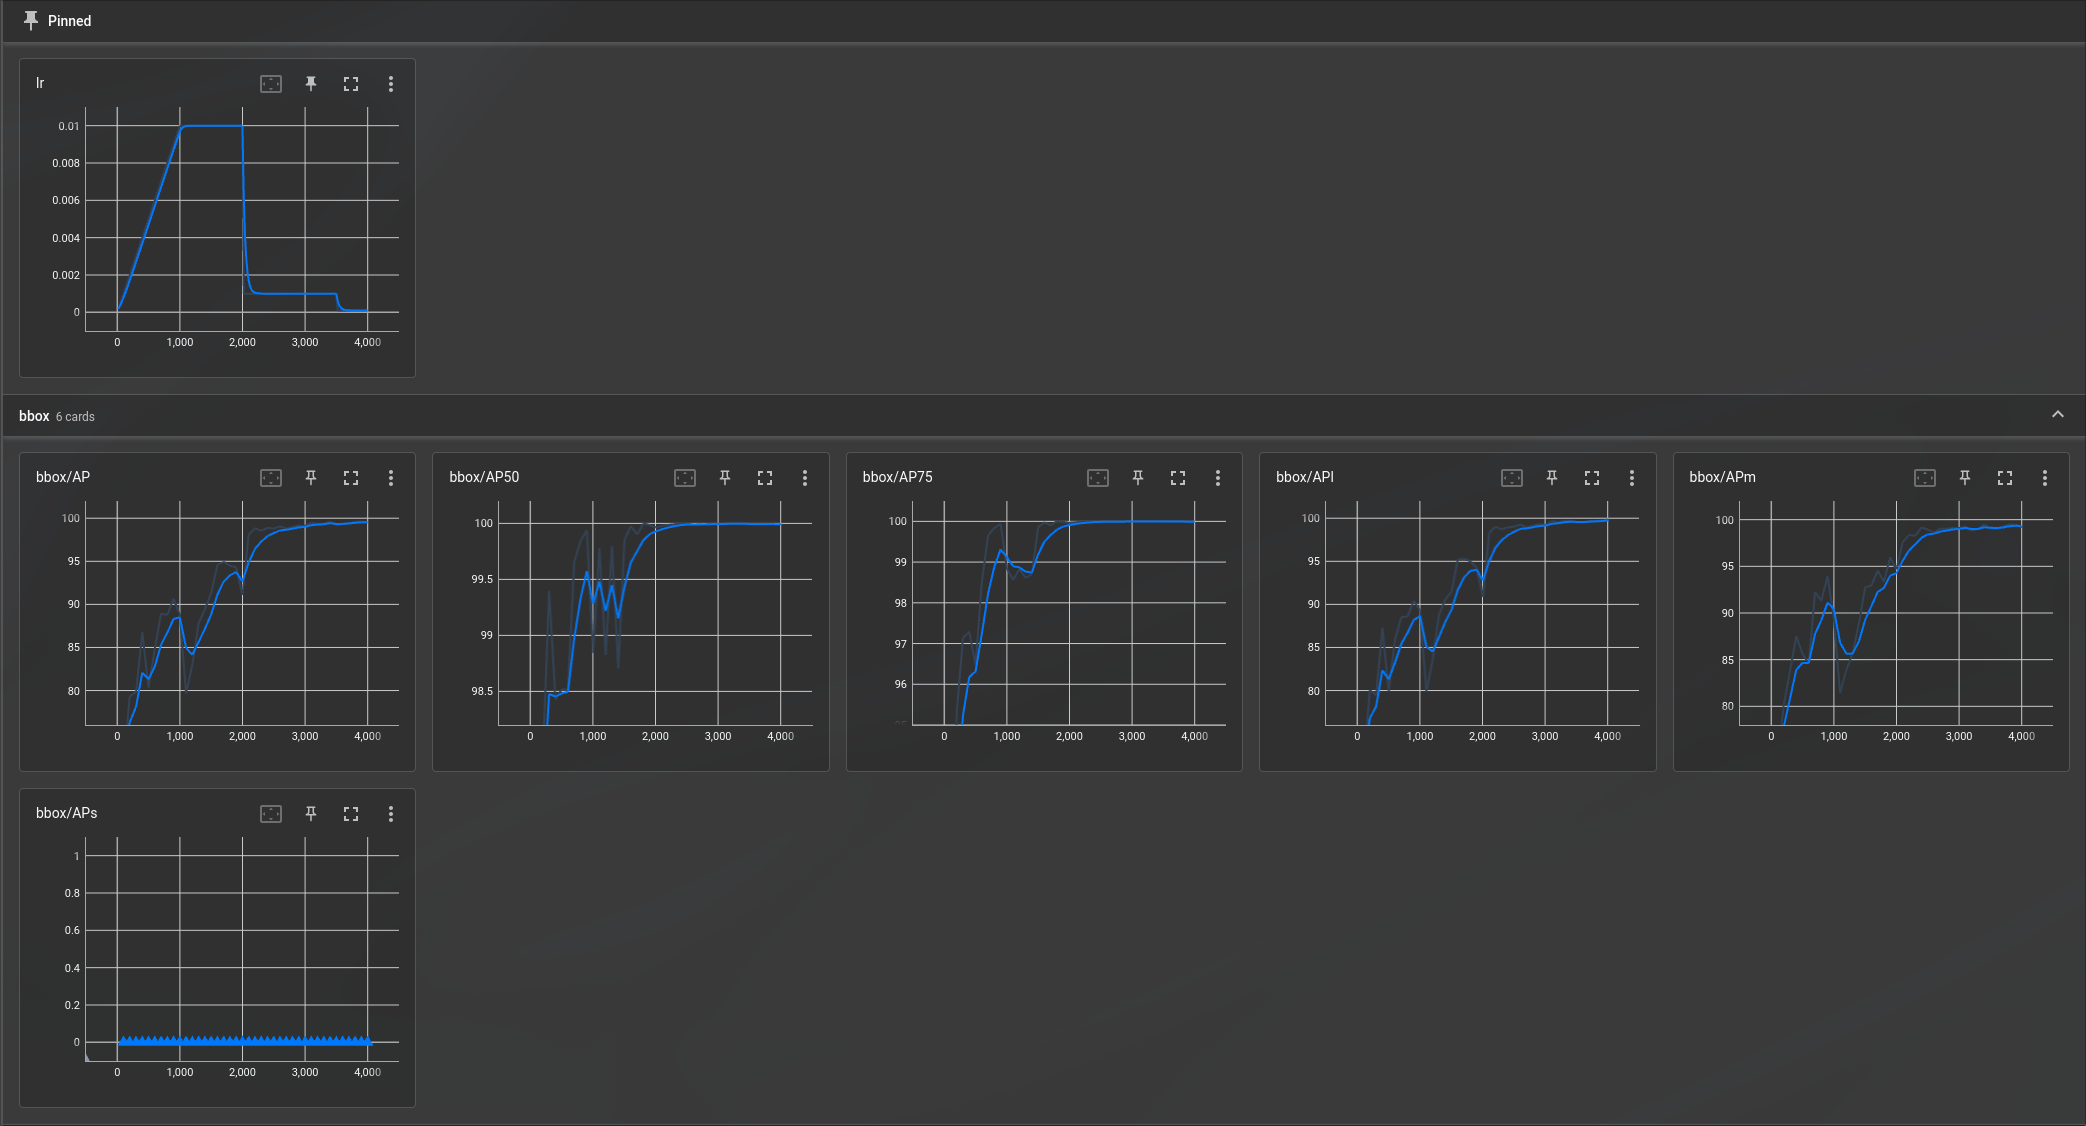

#### What can I see here?

- The lr plot shows how the learning rate changes
    - I can see that the lr was steadily increasing until it tapered off at 0.01 (10e-3), then dropped to around 0.001, then to 0.0001
- The bbox/AP shows the Average Precision for the bounding boxes drawn by the model
- The bbox/AP50 and bbox/AP75 show the average precision with an IoU of 50 or 70 percent
- The APl, APm, APs plots are the Average Precision for Large, Medium and Small objects
    - There are no small objects in the dataset, so this value is NaN, though it still shows up in the graph as 0

#### Would I change certain hyperparameters?

When I turn off the smoothing for these plots, I can see that around iteration 1'100, the AP dropped to 78%, and then began climbing again. From this, I think I might not increase the learning rate to 0.01. I might increase it to a slightly lower value, or extend the lr warmup.

After a while, the precision graphs become logarithmic, which wasn't a problem in this assignment, because the training time took only 1h, but if the model was larger, I would maybe stop the training process prematurely to save time/cost/energy.


---
## Question 7: Look for the right settings during testing:

#### 1. Apply a score threshold of 0.8, what does this mean?

The threshold value determines how confident the model has to be about a bounding box for it to show up in the results.

So a threshold of 0.8 means that all detections with a confidence score of less than 0.8 will be discarded.

In [12]:
cfg.MODEL.WEIGHTS = "/home/atvars/School/advanced_ai/session2/chickens/output/model_final.pth"  # Path to my saved model weights
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.5  # Default value, because I ran this cell again after the following cells


In [ ]:
evaluator = COCOEvaluator("my_dataset_val", cfg, False, output_dir="/home/atvars/School/advanced_ai/session2/evaluation/threshold_08/")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")

predictor = DefaultPredictor(cfg)
results_thresh_08 = inference_on_dataset(predictor.model, val_loader, evaluator)

#### 2. Apply an NMS threshold of 0.3, what does this mean? What happens if we set this to 0? and to 1?

A non-maximum supression threshold of 0.3 means that boxes with an intersection over union larger than 0.3 will be discarded. Non-maximum, because the box that is discarded is determined by the confidence of the model about the prediction it made. The box that has the lower score gets deleted.

0.3 is a low value for this parameter, so the number of overlapping bounding boxes will be relatively large. In this use case, I think it is more fitting, because chickens tend to be close together.

Actually, looking at the dataset, I think it should be even lower, because the tail of a chicken is often covering a part of the other chicken. Since they are more long than wide, the tail of the front chicken is actually covering a pretty significant part of the hind chicken.

In [38]:
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.3  # Set NMS threshold
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set score threshold back down to 0.5
print(cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST)

0.3


In [ ]:
evaluator = COCOEvaluator("my_dataset_val", cfg, False, output_dir="/home/atvars/School/advanced_ai/session2/evaluation/nms03/")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")

predictor = DefaultPredictor(cfg)
results_NMS_03 = inference_on_dataset(predictor.model, val_loader, evaluator)

Setting the NMS to 0

In [40]:
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0  # Set NMS threshold
print(cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST)

0


In [ ]:
evaluator = COCOEvaluator("my_dataset_val", cfg, False, output_dir="/home/atvars/School/advanced_ai/session2/evaluation/nms00/")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")

predictor = DefaultPredictor(cfg)

results_NMS_0 = inference_on_dataset(predictor.model, val_loader, evaluator)

In [ ]:
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 1
evaluator = COCOEvaluator("my_dataset_val", cfg, False, output_dir="/home/atvars/School/advanced_ai/session2/evaluation/nms1/")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")

predictor = DefaultPredictor(cfg)
results_NMS_1 = inference_on_dataset(predictor.model, val_loader, evaluator)

In [ ]:
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.3
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  # Set score threshold
evaluator = COCOEvaluator("my_dataset_val", cfg, False, output_dir="/home/atvars/School/advanced_ai/session2/evaluation/nms1/")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")

predictor = DefaultPredictor(cfg)
results_NMS_03_thresh_08 = inference_on_dataset(predictor.model, val_loader, evaluator)

In [ ]:
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.3
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9  # Set score threshold
evaluator = COCOEvaluator("my_dataset_val", cfg, False, output_dir="/home/atvars/School/advanced_ai/session2/evaluation/nms1/")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")

predictor = DefaultPredictor(cfg)
thresh_09 = inference_on_dataset(predictor.model, val_loader, evaluator)

In [ ]:
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.25
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9  # Set score threshold
evaluator = COCOEvaluator("my_dataset_val", cfg, False, output_dir="/home/atvars/School/advanced_ai/session2/evaluation/nms1/")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")

predictor = DefaultPredictor(cfg)
nms_025 = inference_on_dataset(predictor.model, val_loader, evaluator)

In [ ]:
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.93
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6  # Set score threshold
evaluator = COCOEvaluator("my_dataset_val", cfg, False, output_dir="/home/atvars/School/advanced_ai/session2/evaluation/nms1/")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")

predictor = DefaultPredictor(cfg)
thresh_06_NMS_093 = inference_on_dataset(predictor.model, val_loader, evaluator)

In [ ]:
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.925
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2  # Set score threshold
evaluator = COCOEvaluator("my_dataset_val", cfg, False, output_dir="/home/atvars/School/advanced_ai/session2/evaluation/nms1/")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")

predictor = DefaultPredictor(cfg)
thresh_02_NMS_0925 = inference_on_dataset(predictor.model, val_loader, evaluator)

In [ ]:
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.922
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2  # Set score threshold
evaluator = COCOEvaluator("my_dataset_val", cfg, False, output_dir="/home/atvars/School/advanced_ai/session2/evaluation/nms1/")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")

predictor = DefaultPredictor(cfg)
thresh_02_NMS_0922 = inference_on_dataset(predictor.model, val_loader, evaluator)

### RESULTS:


In [88]:
import pandas as pd

# Assuming your results are stored in OrderedDict variables
results_dict = {
    "Threshold 0.8": results_thresh_08["bbox"],
    "NMS 0.3, Threshold 0.5": results_NMS_03["bbox"],  # Fix the missing variable in your original print statement
    "NMS 0, Threshold 0.5": results_NMS_0["bbox"],
    "NMS 1, Threshold 0.5": results_NMS_1["bbox"],
    "NMS 0.3, Threshold 0.8": results_NMS_03_thresh_08["bbox"],
    "NMS 0.3, Threshold 0.9": thresh_09["bbox"],
    "NMS 0.25, Threshold 0.9": nms_025["bbox"],
    "NMS 0.93, Threshold 0.6": thresh_06_NMS_093["bbox"],
    "NMS 0.925, Threshold 0.2": thresh_02_NMS_0925["bbox"],
    "NMS 0.922, Threshold 0.2": thresh_02_NMS_0922["bbox"]
}

# Convert dictionary to DataFrame
df = pd.DataFrame.from_dict(results_dict, orient='index')

# Display DataFrame
# print(df)
print("All my tested values of NMS and score threshoolds, sorted by AP")
df.head(100).sort_values(by="AP", ascending=False)

# Save to CSV if needed
# df.to_csv("results.csv", index=True)


All my tested values of NMS and score threshoolds, sorted by AP


,AP,AP50,AP75,APs,APm,APl
"NMS 0.922, Threshold 0.2",99.792761,99.973216,99.973216,NaN,99.577544,99.851036
"NMS 0.925, Threshold 0.2",99.778360,99.960105,99.960105,NaN,99.456457,99.851036
"NMS 0.93, Threshold 0.6",99.669970,99.940740,99.940740,NaN,99.331946,99.851036
Threshold 0.8,99.529739,99.993287,99.993287,NaN,99.185729,99.855490
"NMS 0.3, Threshold 0.5",99.529739,99.993287,99.993287,NaN,99.185729,99.855490
"NMS 0.3, Threshold 0.8",99.529739,99.993287,99.993287,NaN,99.185729,99.855490
"NMS 0.3, Threshold 0.9",99.529739,99.993287,99.993287,NaN,99.185729,99.855490
"NMS 0.25, Threshold 0.9",98.838872,99.006533,99.006533,NaN,99.185729,98.866091
"NMS 0, Threshold 0.5",82.131579,82.174143,82.174143,NaN,80.366547,83.137230
"NMS 1, Threshold 0.5",50.122476,50.184721,50.184721,NaN,69.328604,51.448875


### Conclusions:

1. Changing the NMS theshold from 0.5 (default) to 0 or 1 is not a good idea, as all the metrics are worse with these hyperparameters.
2. My hypothesis of having the NMS threshold be a small value was wrong. Having the NMS be close to 0 gives a lot better Average Precision.
3. For a large hyperparameter space, the average precision is ~99.52, but it can be better
    - From my manual testing, the best hyperparameters were `NMS = 0.922` and `SCORE_THRESH = 0.2`, with an AP of ~99.8
    - When the AP went up, it only increased for the medium sized bounding boxes

#### 3. Do we like a higher precision or a higher recall? Is this true for the chosen values of SCORE and NMS?

Precision makes more sense, because the model either predicts a chicken, or doesn't predict anything.

So, when we evaluate the model, it would make more sense to look at all the chickens it predicted, and check whether they are actually chickens.

Otherwise, the model might make a lot of false predictions, just to reach a high number of correctly predicted chickens. 

This way, the model maybe doesn't detect *all* the chickens, but we can be almost certain that what it has predicted to be a chicken is a chicken.

For the chosen values of SCORE and NMS, the precision is maximised.

#### Using `Optuna` for Bayesian optimization

In [ ]:
import optuna

def objective(trial):
    results = 100
    global cfg
    
    cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = trial.suggest_float("nms_thresh", 0.8, 1) # Search space found from previous tests
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = trial.suggest_float("score_thresh", 0.05, 0.5)
    
    while results > 1: # Because sometimes the AP is reported as >1
        evaluator = COCOEvaluator("my_dataset_val", cfg, False, output_dir="/home/atvars/School/advanced_ai/session2/evaluation/optuna/")
        val_loader = build_detection_test_loader(cfg, "my_dataset_val")
        predictor = DefaultPredictor(cfg)
        
        results = inference_on_dataset(predictor.model, val_loader, evaluator)
        results = results["bbox"]['AP']

    return results

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

I deleted the cell output because it took up too much space

In [35]:
trials_df = study.trials_dataframe()
trials_df.value.rename("AP", inplace=True)
trials_df.head(6).sort_values(by="value", ascending=False)

,number,value,datetime_start,datetime_complete,duration,params_nms_thresh,params_score_thresh,state
2,2,0.397482,2025-03-08 18:57:44.115935,2025-03-08 18:58:01.061072,0 days 00:00:16.945137,0.895108,0.310103,COMPLETE
4,4,0.173314,2025-03-08 18:58:18.400652,2025-03-08 18:58:53.070378,0 days 00:00:34.669726,0.929453,0.262203,COMPLETE
3,3,0.139834,2025-03-08 18:58:01.061862,2025-03-08 18:58:18.399805,0 days 00:00:17.337943,0.800003,0.101798,COMPLETE
0,0,0.126735,2025-03-08 18:57:09.515638,2025-03-08 18:57:26.818073,0 days 00:00:17.302435,0.988311,0.485541,COMPLETE
1,1,0.051366,2025-03-08 18:57:26.818974,2025-03-08 18:57:44.115307,0 days 00:00:17.296333,0.871845,0.061286,COMPLETE
5,5,0.026188,2025-03-08 18:58:53.071134,2025-03-08 18:59:10.130407,0 days 00:00:17.059273,0.922415,0.267338,COMPLETE


In [32]:
best_thresh = 0.49811096522623244 # Hardcoded the best values it found from a previous run
best_nms = 0.9319628205165272

cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = best_nms
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = best_thresh

evaluator = COCOEvaluator("my_dataset_val", cfg, False, output_dir="/home/atvars/School/advanced_ai/session2/evaluation/nms1/")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")

predictor = DefaultPredictor(cfg)
supposedly_best_results = inference_on_dataset(predictor.model, val_loader, evaluator)


[03/08 18:54:31 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [03/08 18:54:31 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[03/08 18:54:31 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/08 18:54:31 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[03/08 18:54:31 d2.data.common]: Serializing 112 elements to byte tensors and concatenating them all ...
[03/08 18:54:31 d2.data.common]: Serialized dataset takes 0.22 MiB
[03/08 18:54:32 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl ...


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, we

[03/08 18:54:32 d2.evaluation.evaluator]: Start inference on 112 batches
[03/08 18:54:34 d2.evaluation.evaluator]: Inference done 11/112. Dataloading: 0.0010 s/iter. Inference: 0.1428 s/iter. Eval: 0.0003 s/iter. Total: 0.1441 s/iter. ETA=0:00:14
[03/08 18:54:39 d2.evaluation.evaluator]: Inference done 47/112. Dataloading: 0.0013 s/iter. Inference: 0.1404 s/iter. Eval: 0.0003 s/iter. Total: 0.1421 s/iter. ETA=0:00:09
[03/08 18:54:44 d2.evaluation.evaluator]: Inference done 85/112. Dataloading: 0.0013 s/iter. Inference: 0.1371 s/iter. Eval: 0.0003 s/iter. Total: 0.1387 s/iter. ETA=0:00:03
[03/08 18:54:48 d2.evaluation.evaluator]: Total inference time: 0:00:14.909944 (0.139345 s / iter per device, on 1 devices)
[03/08 18:54:48 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:14 (0.137520 s / iter per device, on 1 devices)
[03/08 18:54:48 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[03/08 18:54:48 d2.evaluation.coco_evaluation]: Saving results to

#### Conclusion:

It's clear that Optuna overfitted on the test set.

The values reported in the training runs and the `trials_df` significantly differ from the values I get by testing the best parameters in an individual run.

I also found that sometimes the AP gets reported wrong. The value comes out as larger than 1.

I tried re-running the inference in those cases, by using a while loop where I make sure that the value is lower than 1, but this just avoids the issue, so I decided to stop testing.

---
## Question 8: Write a metric that calculates the absolute difference between the amount of labeled objects and the amount of detected objects and apply it on the test set. Is this a good metric? Why?/Why not?

Hint1: You can use the 'Counter' metric on
[here](https://detectron2.readthedocs.io/en/latest/tutorials/evaluation.html) to calculate the
amount of detected objects


Hint2: The amount of labeled objects can be calculated from the test DatasetCatalog json

In [ ]:
from detectron2.evaluation import DatasetEvaluator

In [ ]:
class ExampleCounter(DatasetEvaluator):
  def reset(self):
    self.count = 0
  def process(self, inputs, outputs):
    for output in outputs:
      self.count += len(output["instances"])
  def evaluate(self):
    # save self.count somewhere, or print it, or return it.
    return {"count": self.count}

In [ ]:
class Counter(DatasetEvaluator):
    def __init__(self, dataset_name):
        self.dataset_name = dataset_name
        self.metadata = MetadataCatalog.get(dataset_name)
        # Get the dataset dicts from the catalog for ground truth information
        self.dataset_dicts = DatasetCatalog.get(dataset_name)
        self.reset()
    
    def reset(self):
        self.total_gt = 0  # Ground truth object count
        self.total_detected = 0  # Detected object count
        self.image_ids_seen = set()  # To track which images we've processed
    
    def process(self, inputs, outputs):
        for input, output in zip(inputs, outputs):
            # Store the image_id to know which annotations to count
            image_id = input.get("image_id")
            self.image_ids_seen.add(image_id)
            
            # Count detections from model output
            if "instances" in output:
                instances = output["instances"].to("cpu")
                self.total_detected += len(instances)
    
    def evaluate(self):
        # Count ground truth annotations from the dataset
        for dataset_dict in self.dataset_dicts:
            if dataset_dict["image_id"] in self.image_ids_seen:
                if "annotations" in dataset_dict:
                    self.total_gt += len(dataset_dict["annotations"])
        
        abs_diff = abs(self.total_gt - self.total_detected)
        return {
            "absolute_difference": abs_diff,
            "total_gt": self.total_gt, 
            "total_detected": self.total_detected
        }

In [ ]:
counter_evaluator = Counter(test_set_name)
val_loader = build_detection_test_loader(cfg, "my_dataset_val")

predictor = DefaultPredictor(cfg)

counter_results = inference_on_dataset(predictor.model, val_loader, counter_evaluator)


print("Counter Results:", counter_results)


[03/08 14:53:08 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/08 14:53:08 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[03/08 14:53:08 d2.data.common]: Serializing 112 elements to byte tensors and concatenating them all ...
[03/08 14:53:08 d2.data.common]: Serialized dataset takes 0.22 MiB
[03/08 14:53:09 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/atvars/School/advanced_ai/session2/chickens/output/model_final.pth ...
[03/08 14:53:09 d2.evaluation.evaluator]: Start inference on 112 batches
[03/08 14:53:11 d2.evaluation.evaluator]: Inference done 11/112. Dataloading: 0.0009 s/iter. Inference: 0.1440 s/iter. Eval: 0.0001 s/iter. Total: 0.1450 s/iter. ETA=0:00:14
[03/08 14:53:16 d2.evaluation.evaluator]: Inference done 47/112. Dataloading: 0.0013 s/iter. Inference: 0.1402 s/iter

### Is this a good metric?

No, it only counts how many detections my model made. With this approach, I don't need to train a model at all, just adjust the hyperparameters until whatever it detects, it detects the same number of times as the chickens.

By itself, I don't think that this is a good metric, but if it is combined with a proper bounding box evaluation metric like AP or AR, it can give more insight on how well the model is doing.